In [ ]:
[%cd drive/MyDrive/MesDossiers/Master CNN/supervised_project


/content/drive/MyDrive/MesDossiers/Master CNN/supervised_project


In [ ]:
%cd MADE-for-ASD

/content/drive/MyDrive/MesDossiers/Master CNN/supervised_project/MADE-for-ASD


In [ ]:
#from docopt import docopt
import pandas as pd
import matplotlib.pyplot as plt
import re


In [ ]:
def load_phenotypes_2(pheno_path):

    pheno = pd.read_csv(pheno_path)
    pheno = pheno[pheno['FILE_ID'] != 'no_filename']
    #pheno = pheno[pheno['FILE_ID'].str.contains("NYU")]
    pheno['DX_GROUP'] = pheno['DX_GROUP'].apply(lambda v: int(v)-1)
    pheno['SITE_ID'] = pheno['SITE_ID'].apply(lambda v: re.sub('_[0-9]', '', v))
    pheno['SEX'] = pheno['SEX'].apply(lambda v: {1: "M", 2: "F"}[v])
    pheno['SEX'] = pheno['SEX']
    pheno['MEAN_FD'] = pheno['func_mean_fd']
    pheno['SUB_IN_SMP'] = pheno['SUB_IN_SMP'].apply(lambda v: v == 1)
    pheno["STRAT"] = pheno[["SITE_ID", "DX_GROUP"]].apply(lambda x: "_".join([str(s) for s in x]), axis=1)
    pheno["AGE"] = pheno['AGE_AT_SCAN']

    #pheno["FIQ"] = pheno['FIQ'].apply(lambda v: {-9999: '100'}[v])
    pheno["FIQ"] = pheno['FIQ'].fillna(pheno['FIQ'].mean())
    pheno["PIQ"] = pheno['PIQ'].fillna(pheno['PIQ'].mean())
    pheno["VIQ"] = pheno['VIQ'].fillna(pheno['VIQ'].mean())


    pheno['HANDEDNESS_SCORES'] = pheno['HANDEDNESS_SCORES'].fillna(method='bfill')
    pheno.index = pheno['FILE_ID']

    return pheno[['FILE_ID', 'DX_GROUP', 'SEX', 'SITE_ID', 'MEAN_FD', 'SUB_IN_SMP', 'STRAT','AGE','HANDEDNESS_SCORES','FIQ']]



def general_stat(pheno):

    # General stats
    total_count = len(pheno)
    site_counts = pheno["SITE_ID"].value_counts()
    site_percentage = (site_counts / total_count) * 100

    gender_counts = pheno["SEX"].value_counts()
    gender_percentage = (gender_counts / total_count) * 100

    asd_counts = pheno["DX_GROUP"].value_counts()  # 0 = ASD, 1 = Control
    asd_percentage = (asd_counts / total_count) * 100

    # Age groups
    age_under_15 = len(pheno[pheno["AGE"] < 15])
    age_15_to_30 = len(pheno[(pheno["AGE"] >= 15) & (pheno["AGE"] <= 30)])
    age_above_30 = len(pheno[pheno["AGE"] > 30])

    age_groups_percentage = {
        "Under 15": (age_under_15 / total_count) * 100,
        "15 to 30": (age_15_to_30 / total_count) * 100,
        "Above 30": (age_above_30 / total_count) * 100
    }

    # Display general statistics
    print("General Statistics")
    print("------------------")
    print(f"Total Patients: {total_count}")
    print("\nSite Percentage:")
    print(site_percentage)
    print("\nGender Percentage:")
    print(gender_percentage)
    print("\nASD vs Control Percentage:")
    print(asd_percentage)
    print("\nAge Groups Percentage:")
    print(age_groups_percentage)

    # Site-specific stats
    site_stats = []

    for site, group in pheno.groupby("SITE_ID"):
        site_total = len(group)
        male_count = len(group[group["SEX"] == "M"])
        female_count = len(group[group["SEX"] == "F"])
        asd_count = len(group[group["DX_GROUP"] == 0])
        control_count = len(group[group["DX_GROUP"] == 1])
        under_15 = len(group[group["AGE"] < 15])
        age_15_30 = len(group[(group["AGE"] >= 15) & (group["AGE"] <= 30)])
        above_30 = len(group[group["AGE"] > 30])

        # Additional stats for ASD and Control groups
        asd_group = group[group["DX_GROUP"] == 0]
        control_group = group[group["DX_GROUP"] == 1]

        site_stats.append({
            "Site": site,
            "Total": site_total,
            "Male (%)": (male_count / site_total) * 100,
            "Female (%)": (female_count / site_total) * 100,
            "ASD (%)": (asd_count / site_total) * 100,
            "Control (%)": (control_count / site_total) * 100,
            "Under 15 (%)": (under_15 / site_total) * 100,
            "15-30 (%)": (age_15_30 / site_total) * 100,
            "Above 30 (%)": (above_30 / site_total) * 100,
            "ASD Age Mean": asd_group["AGE"].mean(),
            "ASD Age SD": asd_group["AGE"].std(),
            "Control Age Mean": control_group["AGE"].mean(),
            "Control Age SD": control_group["AGE"].std(),
            "ASD Handedness Mean": asd_group["HANDEDNESS_SCORES"].mean(),
            "Control Handedness Mean": control_group["HANDEDNESS_SCORES"].mean(),
            "ASD FIQ Mean": asd_group["FIQ"].mean(),
            "Control FIQ Mean": control_group["FIQ"].mean(),
        })

    # Create the DataFrame
    site_stats_df = pd.DataFrame(site_stats)

    # Display site-specific statistics
    print("\nSite-Specific Statistics")
    print("-------------------------")
    print(site_stats_df.head(20))

    # Plotting
    # 1. Site Percentage
    site_percentage.plot(kind="bar", figsize=(10, 6), title="Percentage of Patients by Site")
    plt.xlabel("Site")
    plt.ylabel("Percentage")
    plt.show()

    # 2. Gender Distribution
    gender_percentage.plot(kind="bar", color=['blue', 'orange'], title="Gender Distribution")
    plt.xlabel("Gender")
    plt.ylabel("Percentage")
    plt.show()

    # 3. ASD vs Control
    asd_percentage.plot(kind="bar", color=['green', 'red'], title="ASD vs Control Percentage")
    plt.xlabel("Group")
    plt.ylabel("Percentage")
    plt.show()

    # 4. Age Groups
    plt.figure(figsize=(8, 6))
    plt.bar(age_groups_percentage.keys(), age_groups_percentage.values(), color=['purple', 'skyblue', 'salmon'])
    plt.title("Age Group Distribution")
    plt.xlabel("Age Group")
    plt.ylabel("Percentage")
    plt.show()

    # 5. Age Groups by Site
    age_group_data = site_stats_df[['Site', 'Under 15 (%)', '15-30 (%)', 'Above 30 (%)']].set_index('Site')
    age_group_data.plot(kind="bar", stacked=True, figsize=(12, 8), title="Age Group Distribution by Site")
    plt.xlabel("Site")
    plt.ylabel("Percentage")
    plt.legend(title="Age Group")
    plt.show()

<ipython-input-16-2a06e54e86af>:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pheno['HANDEDNESS_SCORES'] = pheno['HANDEDNESS_SCORES'].fillna(method='bfill')


,FILE_ID,DX_GROUP,SEX,SITE_ID,MEAN_FD,SUB_IN_SMP,STRAT,AGE,HANDEDNESS_SCORES,FIQ
FILE_ID,,,,,,,,,,
Pitt_0050003,Pitt_0050003,0,M,PITT,0.322092,True,PITT_0,24.45,-60.0,124.0
Pitt_0050004,Pitt_0050004,0,M,PITT,0.127745,True,PITT_0,19.09,-60.0,113.0
Pitt_0050005,Pitt_0050005,0,F,PITT,0.128136,False,PITT_0,13.73,-60.0,119.0
Pitt_0050006,Pitt_0050006,0,M,PITT,0.070143,True,PITT_0,13.37,-60.0,109.0
Pitt_0050007,Pitt_0050007,0,M,PITT,0.151246,True,PITT_0,17.78,-60.0,110.0


General Statistics
------------------
Total Patients: 1035

Site Percentage:
SITE_ID
NYU         16.908213
UM          13.526570
UCLA         9.468599
USM          6.859903
LEUVEN       6.086957
PITT         5.410628
YALE         5.410628
MAX_MUN      5.024155
KKI          4.637681
TRINITY      4.541063
STANFORD     3.768116
CALTECH      3.574879
SDSU         3.478261
OLIN         3.285024
SBL          2.898551
CMU          2.608696
OHSU         2.512077
Name: count, dtype: float64

Gender Percentage:
SEX
M    84.830918
F    15.169082
Name: count, dtype: float64

ASD vs Control Percentage:
DX_GROUP
1    51.207729
0    48.792271
Name: count, dtype: float64

Age Groups Percentage:
{'Under 15': 53.14009661835749, '15 to 30': 39.42028985507247, 'Above 30': 7.439613526570048}

Site-Specific Statistics
-------------------------
        Site  Total    Male (%)  Female (%)    ASD (%)  Control (%)  \
0    CALTECH     37   78.378378   21.621622  51.351351    48.648649   
1        CMU     27   77

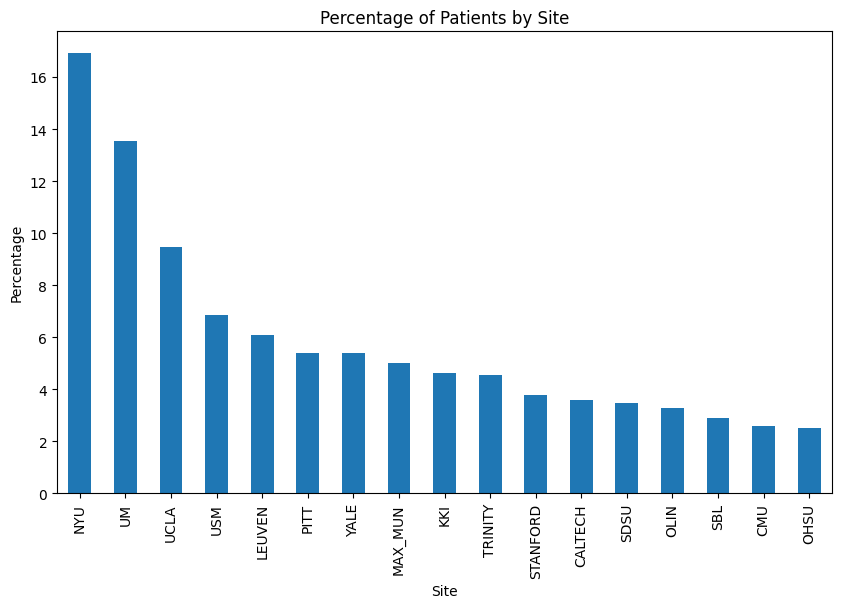

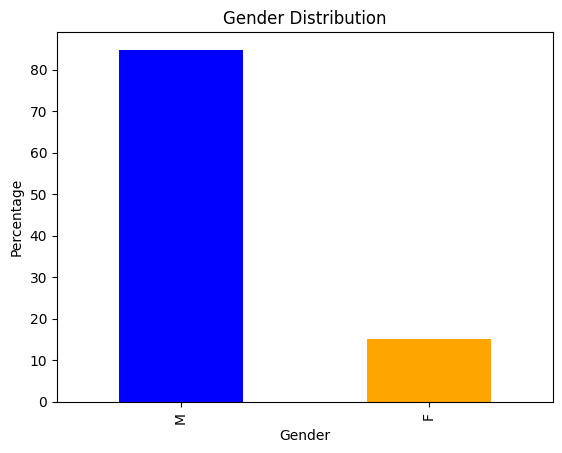

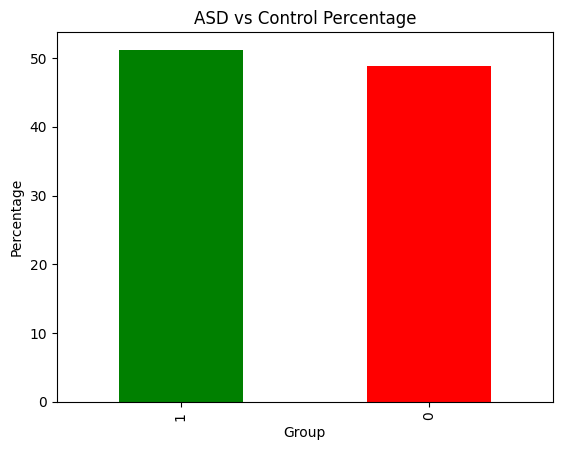

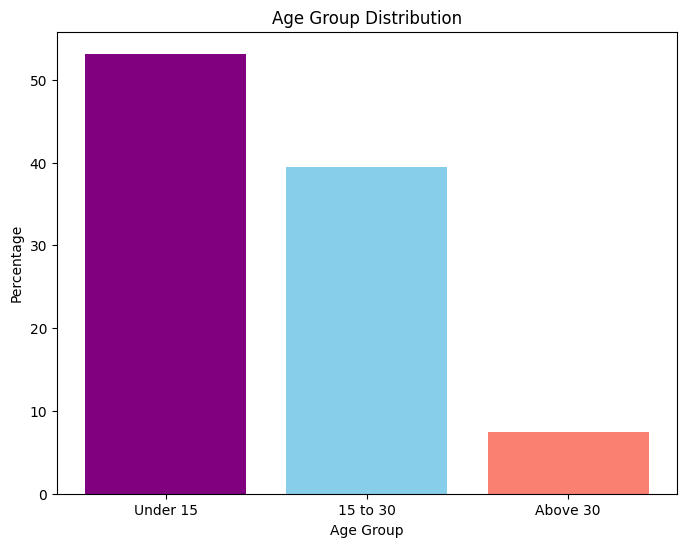

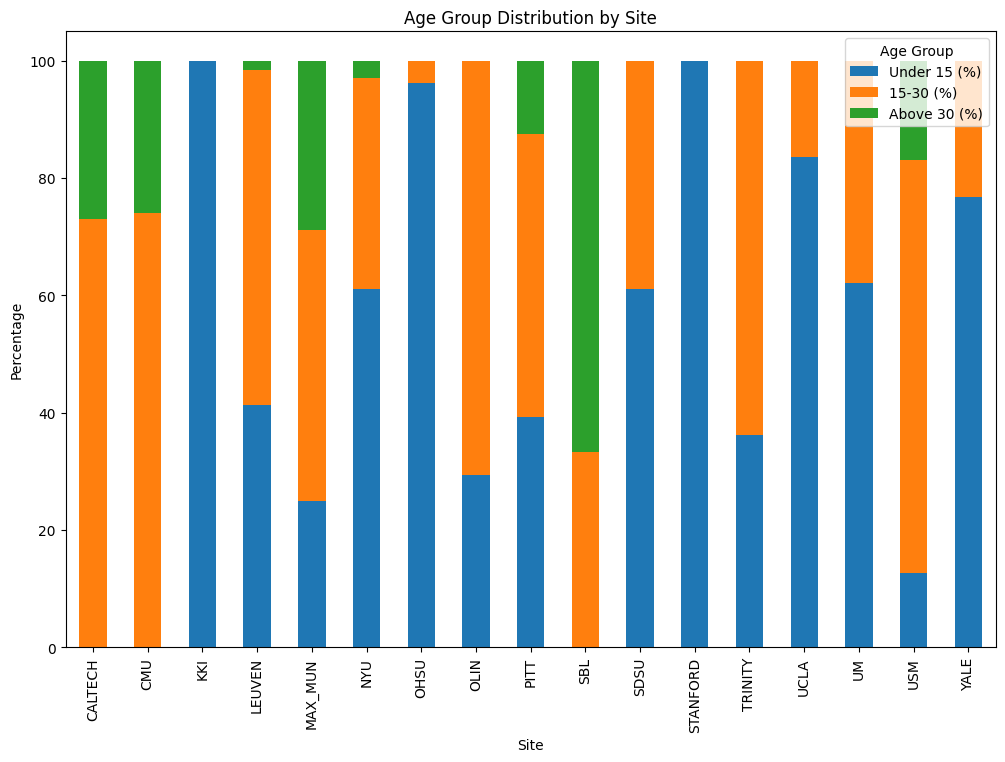

In [ ]:
if __name__ == "__main__":

    pheno_path = "./data/phenotypes/Phenotypic_V1_0b_preprocessed1.csv"
    """   df_brut= pd.read_csv("./data/phenotypes/Phenotypic_V1_0b_preprocessed1.csv")
    # Calculate NaN percentage for each column
    nan_percentage = df_brut.isna().mean() * 100
    nan_percentage_df = nan_percentage[nan_percentage > 0].to_frame(name='NaN Percentage')
    nan_percentage_df.columns.name = 'Column'
    display(nan_percentage_df)  # This works best in Jupyter notebooks
    """
    #pheno_path = "./data/phenotypes/Phenotypic_V1_0b.csv"
    pheno = load_phenotypes_2(pheno_path)
    display(pheno.head())
    general_stat(pheno)